# MONAI Hands-On Demonstrations
## Medical Open Network for AI

This notebook contains practical, straightforward demonstrations of MONAI's key features:
1. **Basic Medical Image Loading & Preprocessing**
2. **2D Medical Image Classification**
3. **3D Medical Image Segmentation**
4. **Data Augmentation for Medical Images**
5. **Transfer Learning with Pre-trained Models**

MONAI is specifically designed for healthcare imaging with PyTorch.

## Notebook Overview and How to Use

This notebook gives you hands-on, end-to-end demos of MONAI for medical imaging. It’s designed to be copy-run-learn: every section is runnable and explains what and why.

What’s inside (demos):
1. Basic image loading and preprocessing with MONAI transforms
2. Data augmentation for medical images
3. 2D classification with DenseNet121
4. 3D segmentation with U-Net
5. Medical imaging metrics (Dice, Hausdorff, confusion matrix)
6. Model zoo architectures (DenseNet, ResNet, EfficientNet, U-Net, SegResNet, UNETR)
7. MONAI Bundles (pretrained models and configs)
8. Advanced preprocessing (windowing, normalization, thresholding, augmentations)

Who this is for:
- Practitioners new to MONAI
- Students and researchers prototyping quickly
- Engineers moving from generic CV to medical imaging

Prerequisites (auto-installed in the first code cell):
- Python 3.9+
- PyTorch
- MONAI
- matplotlib, scikit-image

How to run:
- Step 1: Run the install cell (Cell 2) to ensure dependencies are present.
- Step 2: Run the demos top-to-bottom in order.
- Step 3 (optional): Switch synthetic data to your own data (NIfTI/DICOM) using LoadImageD.
- Step 4 (optional): Try a MONAI Bundle to run a pretrained model.

Data used here:
- Synthetic arrays are generated so everything runs offline and instantly.
- To use your data, create dictionaries like {"image": <ndarray>, "label": <int/ndarray>},
  add a channel dimension (C, ...), and apply dictionary transforms (…d) with keys=["image", …].

Runtime and device:
- GPU is auto-detected; CPU works fine for 2D demos. 3D segmentation may be slower on CPU.
- macOS/Apple Silicon: PyTorch + MONAI run on CPU by default; Metal acceleration is experimental.

Common pitfalls (already handled in this notebook):
- Channel dimension: For grayscale images add (1, H, W) or (1, D, H, W) before transforms.
- Dict vs array transforms: With MONAI Dataset, use dictionary transforms (ScaleIntensityd, Resized, etc.) and set keys explicitly.
- Shapes: 2D expects (B, C, H, W). 3D expects (B, C, D, H, W).
- Dtypes: float32 for images; integer labels for classification/segmentation.

Tips:
- Keep training transforms and validation transforms separate (no augmentation in validation).
- Start with small images/volumes and small batch sizes; scale up once everything runs.
- Visualize transforms often to verify correctness.


In [19]:
# Install MONAI and dependencies
!pip install monai
!pip install matplotlib scikit-image
!pip install pytorch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement pytorch (from versions: none)
ERROR: No matching distribution found for pytorch
ERROR: Could not find a version that satisfies the requirement pytorch (from versions: none)
ERROR: No matching distribution found for pytorch


## Demo 1: Basic Medical Image Loading & Preprocessing
Load and preprocess medical images with MONAI's transforms

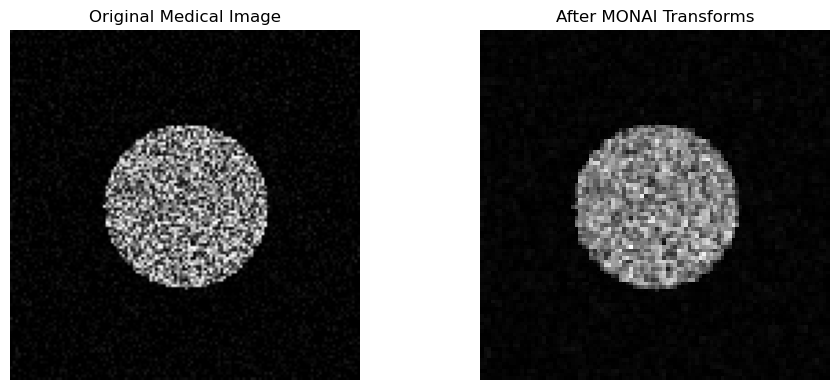

Original shape: (128, 128)
Transformed shape: torch.Size([1, 96, 96])
Transformed range: [0.000, 0.942]


In [20]:
# ============================================================================
# IMPORT NECESSARY LIBRARIES
# ============================================================================

import numpy as np  # For numerical operations and array manipulation
import torch  # PyTorch - deep learning framework
import matplotlib.pyplot as plt  # For plotting and visualization

# MONAI transforms - preprocessing and augmentation tools for medical images
from monai.transforms import (
    Compose,  # Chain multiple transforms together
    LoadImage,  # Load images from files
    EnsureChannelFirst,  # Ensure channel dimension is first
    ScaleIntensity,  # Normalize pixel intensities
    Resize,  # Resize images to specific dimensions
    RandRotate,  # Random rotation augmentation
    RandFlip  # Random flip augmentation
)

# MONAI data utilities for creating datasets and data loaders
from monai.data import Dataset, DataLoader

# ============================================================================
# CREATE SYNTHETIC MEDICAL IMAGE DATA
# ============================================================================

def create_synthetic_medical_image():
    """
    Simulate a 2D medical image slice (like a CT or MRI scan).
    
    This function creates a synthetic grayscale medical image with:
    - A circular structure (simulating an organ)
    - Random intensity variations (simulating tissue density)
    - Gaussian noise (simulating scanner noise)
    
    Returns:
        numpy.ndarray: 128x128 grayscale image with float32 values
    """
    # Initialize a blank 128x128 image (all pixels are 0)
    img = np.zeros((128, 128))
    
    # Create coordinate grids for drawing a circle
    # ogrid creates open mesh grids - efficient for coordinate operations
    # Range from -64 to 64 centers the circle in the 128x128 image
    y, x = np.ogrid[-64:64, -64:64]
    
    # Create circular mask using the equation: x² + y² ≤ r²
    # Where r = 30 pixels (radius of the simulated organ)
    mask = x**2 + y**2 <= 30**2
    
    # Fill the circular region with random intensities
    # - mask.sum() gives the number of pixels in the circle
    # - np.random.rand() generates values between 0 and 1
    # - Multiply by 255 to get values in range [0, 255] (standard image range)
    # - Add 50 as baseline to ensure the organ is brighter than background
    img[mask] = np.random.rand(mask.sum()) * 255
    
    # Add Gaussian noise to simulate scanner noise
    # - np.random.randn() generates normal distribution (mean=0, std=1)
    # - Multiply by 10 to control noise intensity
    img += np.random.randn(128, 128) * 10
    
    # Clip values to valid range [0, 255] to prevent overflow
    img = np.clip(img, 0, 255)
    
    # Convert to float32 (standard for neural networks - balances precision and memory)
    return img.astype(np.float32)

# ============================================================================
# GENERATE SAMPLE IMAGE
# ============================================================================

# Create one sample medical image for demonstration
sample_image = create_synthetic_medical_image()

# ============================================================================
# DEFINE MONAI PREPROCESSING PIPELINE
# ============================================================================

# Compose chains multiple transforms to be applied sequentially
# Note: We don't use EnsureChannelFirst here because we add the channel manually
transforms = Compose([
    # ScaleIntensity: Normalize pixel values to range [0, 1]
    # This is crucial for neural networks to converge during training
    ScaleIntensity(),
    
    # Resize: Standardize all images to 96x96 pixels
    # Neural networks require fixed input sizes
    # 96x96 is chosen as a balance between detail and computational cost
    Resize((96, 96)),
])

# ============================================================================
# APPLY TRANSFORMS
# ============================================================================

# Add channel dimension manually using numpy's newaxis
# - Original shape: (128, 128) - height x width
# - After newaxis: (1, 128, 128) - channels x height x width
# Medical grayscale images have 1 channel (unlike RGB with 3 channels)
sample_image_with_channel = sample_image[np.newaxis, ...]

# Apply the preprocessing pipeline
# transformed will have shape (1, 96, 96) after ScaleIntensity and Resize
transformed = transforms(sample_image_with_channel)

# ============================================================================
# VISUALIZE RESULTS
# ============================================================================

# Create a figure with 1 row and 2 columns for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot original image
axes[0].imshow(sample_image, cmap='gray')  # cmap='gray' for grayscale visualization
axes[0].set_title('Original Medical Image')
axes[0].axis('off')  # Hide axis ticks for cleaner visualization

# Plot transformed image
# .squeeze() removes the channel dimension for visualization: (1, 96, 96) -> (96, 96)
axes[1].imshow(transformed.squeeze(), cmap='gray')
axes[1].set_title('After MONAI Transforms')
axes[1].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# ============================================================================
# PRINT INFORMATION
# ============================================================================

print(f"Original shape: {sample_image.shape}")  # Expected: (128, 128)
print(f"Transformed shape: {transformed.shape}")  # Expected: (1, 96, 96)
print(f"Transformed range: [{transformed.min():.3f}, {transformed.max():.3f}]")  # Expected: ~[0.0, 1.0]

## Demo 2: Data Augmentation Pipeline
Medical imaging augmentation techniques

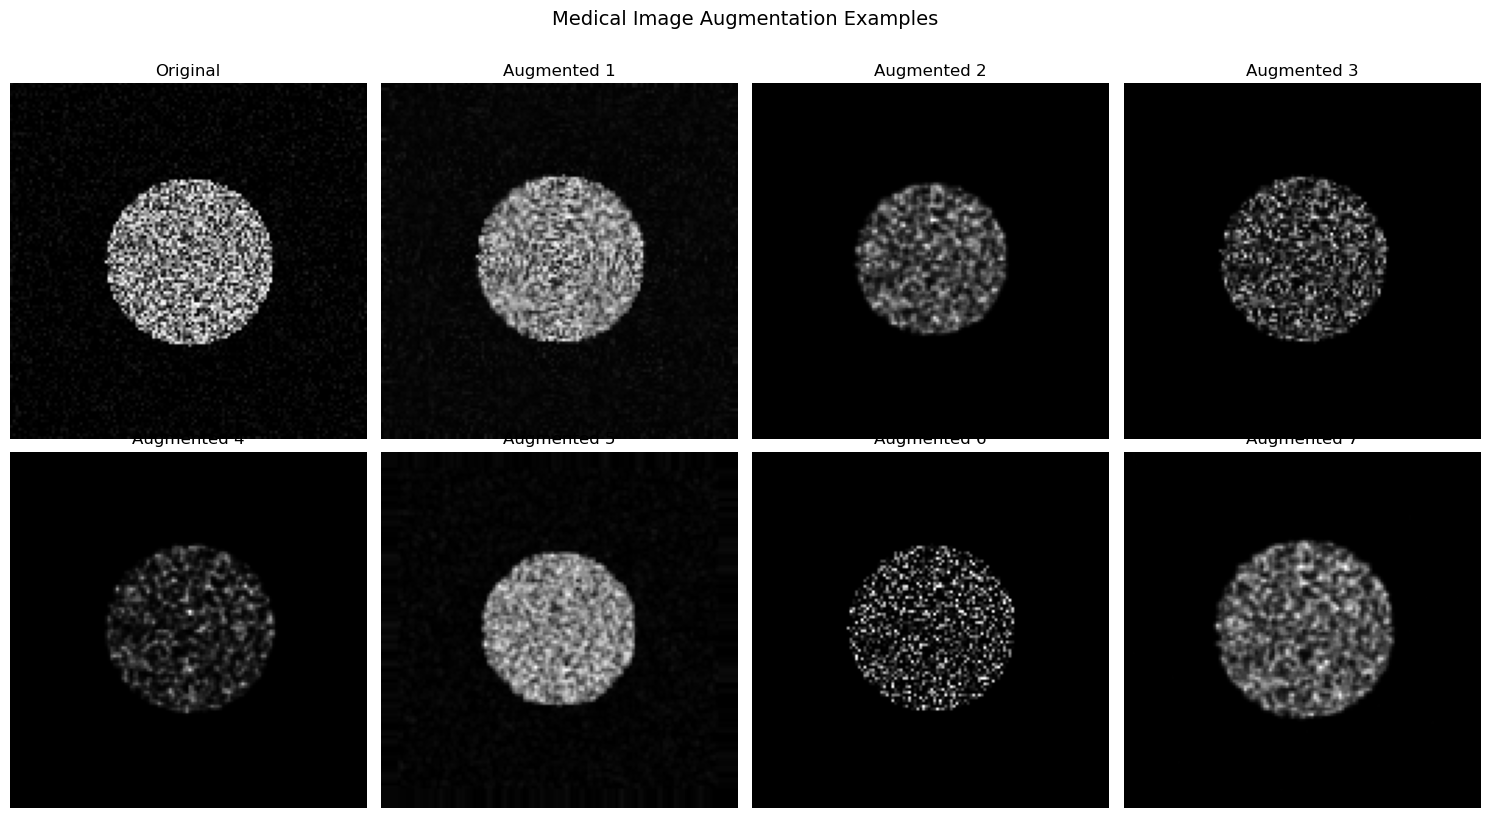

✓ Each augmented image has random transformations applied
✓ Notice how each version looks slightly different
✓ This helps the neural network learn robust features


In [21]:
# ============================================================================
# IMPORT AUGMENTATION TRANSFORMS
# ============================================================================

from monai.transforms import (
    RandRotate,  # Random rotation - simulates different patient positioning
    RandFlip,  # Random flip - simulates left/right orientation variations
    RandZoom,  # Random zoom - simulates different scanner magnifications
    RandGaussianNoise,  # Add random noise - simulates scanner variations
    RandAdjustContrast  # Adjust contrast - simulates different scanner settings
)

# ============================================================================
# DEFINE AUGMENTATION PIPELINE
# ============================================================================

# Data augmentation creates variations of training images to:
# 1. Increase dataset size artificially
# 2. Make the model more robust to variations
# 3. Prevent overfitting (memorizing training data)

augmentation_transforms = Compose([
    # ScaleIntensity: Normalize to [0, 1] range first
    ScaleIntensity(),
    
    # RandRotate: Randomly rotate the image
    # - range_x=0.3: Rotate up to ±0.3 radians (~17 degrees)
    # - prob=0.8: Apply this transform 80% of the time
    # Simulates different patient head/body orientations
    RandRotate(range_x=0.3, prob=0.8),
    
    # RandFlip: Randomly flip the image horizontally
    # - spatial_axis=0: Flip along first spatial axis (horizontal)
    # - prob=0.5: Apply 50% of the time (coin flip)
    # Simulates left/right patient positioning
    RandFlip(spatial_axis=0, prob=0.5),
    
    # RandZoom: Randomly zoom in/out
    # - min_zoom=0.9: Can zoom out to 90% of original size
    # - max_zoom=1.1: Can zoom in to 110% of original size
    # - prob=0.5: Apply 50% of the time
    # Simulates different scanner field-of-view settings
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    
    # RandGaussianNoise: Add random Gaussian noise
    # - prob=0.3: Apply 30% of the time
    # - std=0.01: Standard deviation of noise (low intensity)
    # Simulates scanner electronic noise and artifacts
    RandGaussianNoise(prob=0.3, std=0.01),
    
    # RandAdjustContrast: Randomly adjust image contrast
    # - prob=0.5: Apply 50% of the time
    # Simulates different scanner contrast settings and protocols
    RandAdjustContrast(prob=0.5),
])

# ============================================================================
# VISUALIZE MULTIPLE AUGMENTED VERSIONS
# ============================================================================

# Create figure with 2 rows x 4 columns = 8 subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()  # Convert 2D array to 1D for easier indexing

# First subplot: Show the original image
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Generate 7 different augmented versions
for i in range(1, 8):
    # Add channel dimension: (128, 128) -> (1, 128, 128)
    # This is required by MONAI transforms
    sample_with_channel = sample_image[np.newaxis, ...]
    
    # Apply augmentation pipeline
    # Each run produces a DIFFERENT result due to random operations
    # This demonstrates how we can create multiple training examples from one image
    augmented = augmentation_transforms(sample_with_channel)
    
    # Display the augmented image
    # .squeeze() removes channel dimension for visualization: (1, H, W) -> (H, W)
    axes[i].imshow(augmented.squeeze(), cmap='gray')
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

# Add overall title to the figure
plt.suptitle('Medical Image Augmentation Examples', fontsize=14, y=1.02)
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

print("✓ Each augmented image has random transformations applied")
print("✓ Notice how each version looks slightly different")
print("✓ This helps the neural network learn robust features")

## Demo 3: 2D Medical Image Classification
Train a simple CNN to classify medical images

In [22]:
# ============================================================================
# IMPORT CLASSIFICATION COMPONENTS
# ============================================================================

from monai.networks.nets import DenseNet121  # Pre-built DenseNet architecture
from monai.losses import FocalLoss  # Loss function for imbalanced datasets
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms (Adam, SGD, etc.)

# Import dictionary-based transforms for working with MONAI Dataset
from monai.transforms import (
    ScaleIntensityd,  # Dictionary version of ScaleIntensity
    Resized,  # Dictionary version of Resize
    RandRotated,  # Dictionary version of RandRotate
    RandFlipd,  # Dictionary version of RandFlip
)

# ============================================================================
# CREATE SYNTHETIC CLASSIFICATION DATASET
# ============================================================================

def create_dataset(num_samples=100):
    """
    Create a synthetic binary classification dataset.
    
    Binary classification = 2 classes:
    - Class 0: Healthy (small structure)
    - Class 1: Diseased (large structure)
    
    Args:
        num_samples: Number of images to generate
        
    Returns:
        images: List of numpy arrays (each is 128x128)
        labels: List of integers (0 or 1)
    """
    images = []  # Store all generated images
    labels = []  # Store corresponding class labels
    
    # Generate specified number of samples
    for i in range(num_samples):
        # Initialize blank image
        img = np.zeros((128, 128))
        
        # Alternate between classes: 0, 1, 0, 1, ...
        # This ensures balanced dataset (50% class 0, 50% class 1)
        label = i % 2  # Modulo operator: returns remainder of i/2
        
        # Class 0: Healthy - Small circular structure
        if label == 0:
            # Create coordinate grid centered at origin
            y, x = np.ogrid[-64:64, -64:64]
            
            # Small circle with radius = 20 pixels
            mask = x**2 + y**2 <= 20**2
            
            # Fill with random intensities in range [50, 250]
            # np.random.rand() gives [0, 1], multiply by 200 gives [0, 200], add 50 gives [50, 250]
            img[mask] = np.random.rand(mask.sum()) * 200 + 50
            
        # Class 1: Diseased - Large circular structure
        else:
            y, x = np.ogrid[-64:64, -64:64]
            
            # Large circle with radius = 40 pixels (2x bigger than healthy)
            mask = x**2 + y**2 <= 40**2
            
            # Same intensity range but larger area
            img[mask] = np.random.rand(mask.sum()) * 200 + 50
        
        # Add Gaussian noise (standard deviation = 5)
        # Simulates realistic scanner noise
        img += np.random.randn(128, 128) * 5
        
        # Clip to valid range and convert to float32
        img = np.clip(img, 0, 255).astype(np.float32)
        
        # Add to lists
        images.append(img)
        labels.append(label)
    
    return images, labels

# ============================================================================
# GENERATE TRAINING AND VALIDATION DATA
# ============================================================================

# Create 80 training samples (40 of each class)
train_images, train_labels = create_dataset(80)

# Create 20 validation samples (10 of each class)
# Validation data is used to monitor model performance during training
val_images, val_labels = create_dataset(20)

# ============================================================================
# DEFINE DICTIONARY-BASED PREPROCESSING TRANSFORMS
# ============================================================================

# Dictionary transforms work with data in format: {"image": array, "label": value}
# The 'd' suffix indicates dictionary version
# keys parameter specifies which dictionary keys to transform

# Training transforms include augmentation for better generalization
train_transforms = Compose([
    # ScaleIntensityd: Normalize to [0, 1]
    # keys=["image"]: Only transform the "image" key, not "label"
    ScaleIntensityd(keys=["image"]),
    
    # Resized: Standardize size to 96x96
    Resized(keys=["image"], spatial_size=(96, 96)),
    
    # RandRotated: Random rotation (less aggressive than before)
    RandRotated(keys=["image"], range_x=0.2, prob=0.5),
    
    # RandFlipd: Random flip
    RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
])

# Validation transforms - NO augmentation
# We want to evaluate model on clean, unmodified data
val_transforms = Compose([
    ScaleIntensityd(keys=["image"]),  # Only normalize
    Resized(keys=["image"], spatial_size=(96, 96)),  # And resize
])

# ============================================================================
# CREATE MONAI DATASETS
# ============================================================================

# Create dictionaries with 'image' and 'label' keys
# This format is required by MONAI's Dataset class
# We add channel dimension here: (128, 128) -> (1, 128, 128)
train_data = [
    {"image": img[np.newaxis, ...], "label": label} 
    for img, label in zip(train_images, train_labels)
]

val_data = [
    {"image": img[np.newaxis, ...], "label": label} 
    for img, label in zip(val_images, val_labels)
]

# ============================================================================
# CREATE MONAI DATASETS AND DATALOADERS
# ============================================================================

# MONAI Dataset: Applies transforms on-the-fly when data is accessed
# This is memory-efficient (doesn't store all transformed versions)
train_ds = Dataset(data=train_data, transform=train_transforms)
val_ds = Dataset(data=val_data, transform=val_transforms)

# DataLoader: Handles batching, shuffling, and parallel loading
# - batch_size=8: Process 8 images at once (balances speed and memory)
# - shuffle=True: Randomize order each epoch (prevents learning order patterns)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

# Validation loader - no shuffling needed
val_loader = DataLoader(val_ds, batch_size=8)

# ============================================================================
# PRINT DATASET INFORMATION
# ============================================================================

print(f"✓ Training samples: {len(train_ds)}")  # Should be 80
print(f"✓ Validation samples: {len(val_ds)}")  # Should be 20

# Get one batch to check shape
# next(iter(...)) gets the first batch from the dataloader
sample_batch = next(iter(train_loader))
print(f"✓ Sample batch shape: {sample_batch['image'].shape}")  # Should be (8, 1, 96, 96)
# (batch_size=8, channels=1, height=96, width=96)

✓ Training samples: 80
✓ Validation samples: 20
✓ Sample batch shape: torch.Size([8, 1, 96, 96])


Using device: cpu
Training MONAI DenseNet121 Model...
Epoch [1/5] - Loss: 0.1099, Val Accuracy: 100.00%
Epoch [1/5] - Loss: 0.1099, Val Accuracy: 100.00%
Epoch [2/5] - Loss: 0.0067, Val Accuracy: 100.00%
Epoch [2/5] - Loss: 0.0067, Val Accuracy: 100.00%
Epoch [3/5] - Loss: 0.0039, Val Accuracy: 100.00%
Epoch [3/5] - Loss: 0.0039, Val Accuracy: 100.00%
Epoch [4/5] - Loss: 0.0015, Val Accuracy: 100.00%
Epoch [4/5] - Loss: 0.0015, Val Accuracy: 100.00%
Epoch [5/5] - Loss: 0.2694, Val Accuracy: 50.00%
✓ Training completed!
Epoch [5/5] - Loss: 0.2694, Val Accuracy: 50.00%
✓ Training completed!


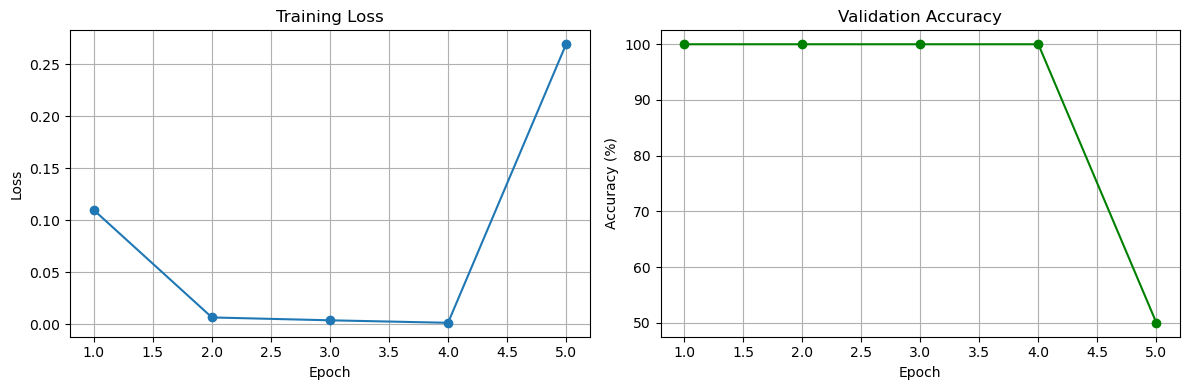


📊 Training Analysis:
   Initial Loss: 0.1099 → Final Loss: 0.2694
   Initial Accuracy: 100.00% → Final Accuracy: 50.00%

   If accuracy increases and loss decreases → Model is learning!
   If loss stops decreasing → Model has converged


In [23]:
# ============================================================================
# INITIALIZE MODEL AND TRAINING COMPONENTS
# ============================================================================

# Determine if GPU is available for faster training
# CUDA = Compute Unified Device Architecture (NVIDIA's parallel computing platform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize MONAI's DenseNet121 model
# DenseNet (Densely Connected Network) is a powerful CNN architecture
# Key parameters:
# - spatial_dims=2: 2D images (use 3 for 3D volumes like CT/MRI)
# - in_channels=1: Grayscale images (use 3 for RGB)
# - out_channels=2: Binary classification (2 classes: healthy vs diseased)
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)

# ============================================================================
# DEFINE LOSS FUNCTION
# ============================================================================

# CrossEntropyLoss: Standard loss for classification tasks
# Combines LogSoftmax and NLLLoss in one class
# Formula: -log(probability of correct class)
# Lower loss = better predictions
criterion = nn.CrossEntropyLoss()

# ============================================================================
# DEFINE OPTIMIZER
# ============================================================================

# Adam (Adaptive Moment Estimation) optimizer
# - Automatically adjusts learning rate for each parameter
# - Generally works well without much tuning
# - lr=1e-3 (0.001): Learning rate - how big steps to take during training
#   (Too high = unstable, too low = slow convergence)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ============================================================================
# TRAINING SETUP
# ============================================================================

num_epochs = 5  # Number of complete passes through training data
train_losses = []  # Store training loss for each epoch (for plotting)
val_accuracies = []  # Store validation accuracy for each epoch (for plotting)

print("Training MONAI DenseNet121 Model...")
print("=" * 50)

# ============================================================================
# TRAINING LOOP
# ============================================================================

# Epoch = one complete pass through all training data
for epoch in range(num_epochs):
    
    # ========================================================================
    # TRAINING PHASE
    # ========================================================================
    
    # Set model to training mode
    # This enables dropout, batch normalization updates, etc.
    model.train()
    
    epoch_loss = 0  # Accumulate loss for this epoch
    
    # Iterate through batches
    # Each batch contains 8 images and their labels
    for batch in train_loader:
        # Move data to GPU (if available)
        images = batch["image"].to(device)  # Shape: (8, 1, 96, 96)
        labels = batch["label"].to(device)  # Shape: (8,)
        
        # Zero the gradients from previous iteration
        # Gradients accumulate by default in PyTorch, so we need to reset them
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        # outputs shape: (8, 2) - 2 values per image (probability for each class)
        outputs = model(images)
        
        # Calculate loss: how different are predictions from true labels?
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients
        # This calculates how much each parameter contributed to the loss
        loss.backward()
        
        # Update weights using computed gradients
        # Optimizer adjusts model parameters to reduce loss
        optimizer.step()
        
        # Accumulate loss for this batch
        epoch_loss += loss.item()
    
    # Calculate average loss across all batches
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # ========================================================================
    # VALIDATION PHASE
    # ========================================================================
    
    # Set model to evaluation mode
    # This disables dropout, freezes batch normalization, etc.
    model.eval()
    
    correct = 0  # Count correct predictions
    total = 0  # Count total predictions
    
    # Disable gradient computation (saves memory and speeds up)
    # We don't need gradients during validation
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            
            # Get predictions
            outputs = model(images)
            
            # Get predicted class (argmax of 2 output values)
            # torch.max returns (values, indices)
            # We only need indices (predicted class: 0 or 1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Count total samples
            total += labels.size(0)
            
            # Count correct predictions
            # (predicted == labels) creates boolean tensor
            # .sum() counts True values
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy as percentage
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

print("=" * 50)
print("✓ Training completed!")

# ============================================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================================

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training Loss
# Loss should generally decrease over epochs
ax1.plot(range(1, num_epochs+1), train_losses, marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot 2: Validation Accuracy
# Accuracy should generally increase over epochs
ax2.plot(range(1, num_epochs+1), val_accuracies, marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n📊 Training Analysis:")
print(f"   Initial Loss: {train_losses[0]:.4f} → Final Loss: {train_losses[-1]:.4f}")
print(f"   Initial Accuracy: {val_accuracies[0]:.2f}% → Final Accuracy: {val_accuracies[-1]:.2f}%")
print("\n   If accuracy increases and loss decreases → Model is learning!")
print("   If loss stops decreasing → Model has converged")

## Demo 4: 3D Medical Image Segmentation
U-Net for volumetric medical image segmentation

In [24]:
# ============================================================================
# IMPORT 3D SEGMENTATION COMPONENTS
# ============================================================================

from monai.networks.nets import UNet  # U-Net architecture - gold standard for segmentation
from monai.losses import DiceLoss  # Dice loss - specialized for segmentation
from monai.metrics import DiceMetric  # Dice metric - measures segmentation quality

# Import dictionary-based transforms
from monai.transforms import ScaleIntensityd

# ============================================================================
# CREATE SYNTHETIC 3D MEDICAL VOLUME
# ============================================================================

def create_3d_medical_volume():
    """
    Simulate a 3D medical volume (like CT or MRI scan).
    
    A 3D volume is a stack of 2D slices (like a 3D cube of data).
    Example: A CT scan of the chest has ~300 slices, each 512x512 pixels.
    
    Returns:
        volume: 3D array (64, 64, 64) - the medical scan
        mask: 3D array (64, 64, 64) - ground truth segmentation
              (1 = organ, 0 = background)
    """
    # Initialize blank 3D volumes
    # Shape: (depth, height, width) or (slices, rows, columns)
    volume = np.zeros((64, 64, 64))
    mask = np.zeros((64, 64, 64))
    
    # Create 3D coordinate grids
    # Each point (z, y, x) represents a voxel (3D pixel) in the volume
    z, y, x = np.ogrid[-32:32, -32:32, -32:32]
    
    # Create spherical region using 3D distance formula: x² + y² + z² ≤ r²
    # This simulates an organ (like spleen, kidney, tumor) in center of scan
    # Radius = 15 voxels
    sphere = x**2 + y**2 + z**2 <= 15**2
    
    # Fill spherical organ with random intensities [50, 250]
    # Different tissues have different densities in CT/MRI
    volume[sphere] = np.random.rand(sphere.sum()) * 200 + 50
    
    # Add 3D Gaussian noise to entire volume
    # Simulates scanner noise present throughout the scan
    volume += np.random.randn(64, 64, 64) * 5
    
    # Clip and convert to float32
    volume = np.clip(volume, 0, 255).astype(np.float32)
    
    # Create ground truth mask
    # 1 = organ voxel, 0 = background voxel
    # This is what we want the model to predict
    mask[sphere] = 1  # Binary segmentation mask
    
    return volume, mask

# ============================================================================
# GENERATE DATASET
# ============================================================================

num_samples = 10  # Create 10 different 3D volumes
volumes = []  # Store all volumes
masks = []  # Store corresponding segmentation masks

print("Generating synthetic 3D medical volumes...")
for i in range(num_samples):
    vol, msk = create_3d_medical_volume()
    volumes.append(vol)
    masks.append(msk)
    if (i + 1) % 5 == 0:
        print(f"  Generated {i + 1}/{num_samples} volumes")

# ============================================================================
# PREPARE DATA FOR TRAINING
# ============================================================================

# Dictionary-based preprocessing: normalize intensities
# For 3D data, we avoid heavy augmentation due to computational cost
seg_transforms = Compose([
    # ScaleIntensityd: Normalize both image and label to [0, 1]
    # keys=["image", "label"]: Transform both dictionary keys
    ScaleIntensityd(keys=["image", "label"]),
])

# Create data dictionaries with channel dimension added
# Format: {
#   'image': (1, 64, 64, 64) - input volume with channel
#   'label': (1, 64, 64, 64) - ground truth mask with channel
# }
seg_data = [
    {
        "image": vol[np.newaxis, ...],  # Add channel: (64,64,64) -> (1,64,64,64)
        "label": msk[np.newaxis, ...]   # Add channel to mask too
    } 
    for vol, msk in zip(volumes, masks)
]

# ============================================================================
# CREATE DATALOADER
# ============================================================================

# DataLoader for 3D segmentation
# batch_size=2: Process 2 volumes at once (3D data is memory-intensive!)
# Lower batch size than 2D due to much larger memory requirements
seg_loader = DataLoader(
    Dataset(data=seg_data, transform=seg_transforms), 
    batch_size=2, 
    shuffle=True
)

# ============================================================================
# PRINT DATASET INFORMATION
# ============================================================================

print(f"\n✓ Created {len(seg_data)} 3D volumes")
print(f"✓ Volume shape: {volumes[0].shape}")  # (64, 64, 64)
print(f"✓ Mask shape: {masks[0].shape}")  # (64, 64, 64)

# Calculate statistics
total_voxels = volumes[0].size
organ_voxels = masks[0].sum()
print(f"✓ Total voxels per volume: {total_voxels:,}")
print(f"✓ Organ voxels (average): {int(organ_voxels):,}")
print(f"✓ Organ percentage: {100 * organ_voxels / total_voxels:.1f}%")
print("\n   Note: Real medical volumes are much larger (e.g., 512x512x300)")

Generating synthetic 3D medical volumes...
  Generated 5/10 volumes
  Generated 10/10 volumes

✓ Created 10 3D volumes
✓ Volume shape: (64, 64, 64)
✓ Mask shape: (64, 64, 64)
✓ Total voxels per volume: 262,144
✓ Organ voxels (average): 14,147
✓ Organ percentage: 5.4%

   Note: Real medical volumes are much larger (e.g., 512x512x300)


In [25]:
# ============================================================================
# INITIALIZE 3D U-NET MODEL
# ============================================================================

# U-Net architecture: Encoder-decoder structure with skip connections
# Originally designed for medical image segmentation
# 
# Architecture overview:
# - Encoder: Progressively downsample and extract features
# - Decoder: Progressively upsample and refine segmentation
# - Skip connections: Connect encoder and decoder at each level
#   (helps preserve spatial information lost during downsampling)

unet_model = UNet(
    spatial_dims=3,  # 3D model (use 2 for 2D images)
    in_channels=1,  # Grayscale input (CT/MRI scans)
    out_channels=2,  # 2 classes: background (0) and organ (1)
    channels=(16, 32, 64),  # Number of filters at each encoder level
                            # Starts with 16, doubles to 32, then 64
                            # More filters = more complex features but more memory
    strides=(2, 2),  # Downsampling factor at each level (halve dimensions)
).to(device)  # Move model to GPU if available

print(f"✓ U-Net initialized on {device}")
print(f"✓ Model parameters: {sum(p.numel() for p in unet_model.parameters()):,}")

# ============================================================================
# DEFINE LOSS FUNCTION FOR SEGMENTATION
# ============================================================================

# Dice Loss: Specialized loss for segmentation tasks
# 
# Dice Coefficient measures overlap between prediction and ground truth:
# Dice = 2 × |Prediction ∩ Ground Truth| / (|Prediction| + |Ground Truth|)
# Range: [0, 1] where 1 = perfect overlap
# 
# Dice Loss = 1 - Dice Coefficient
# So minimizing Dice Loss = maximizing Dice Coefficient
# 
# Why use Dice Loss instead of CrossEntropy?
# - Handles class imbalance well (organ is small compared to background)
# - Directly optimizes the metric we care about (overlap)

dice_loss = DiceLoss(
    to_onehot_y=True,  # Convert integer labels to one-hot encoding
                       # [0, 1, 0, 1] -> [[1,0], [0,1], [1,0], [0,1]]
    softmax=True  # Apply softmax to model outputs (converts to probabilities)
)

# ============================================================================
# DEFINE EVALUATION METRIC
# ============================================================================

# Dice Metric: Measure segmentation quality during validation
# Same as Dice Coefficient (not loss)
dice_metric = DiceMetric(
    include_background=False,  # Only measure dice for organ class (ignore background)
    reduction="mean"  # Average dice score across batch
)

# ============================================================================
# DEFINE OPTIMIZER
# ============================================================================

# Adam optimizer with learning rate 1e-3
seg_optimizer = optim.Adam(unet_model.parameters(), lr=1e-3)

# ============================================================================
# TRAINING LOOP
# ============================================================================

num_epochs = 5  # Number of training epochs
print("\nTraining 3D U-Net for Segmentation...")
print("=" * 50)

for epoch in range(num_epochs):
    # ========================================================================
    # TRAINING PHASE
    # ========================================================================
    
    unet_model.train()  # Set to training mode
    epoch_loss = 0  # Accumulate loss
    
    for batch_idx, batch in enumerate(seg_loader):
        # Get batch data
        # images shape: (2, 1, 64, 64, 64) - batch of 2 volumes
        # labels shape: (2, 1, 64, 64, 64) - corresponding masks
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        
        # Reset gradients
        seg_optimizer.zero_grad()
        
        # Forward pass: predict segmentation
        # outputs shape: (2, 2, 64, 64, 64)
        # 2 channels for 2 classes (background and organ)
        outputs = unet_model(images)
        
        # Calculate Dice Loss
        loss = dice_loss(outputs, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update weights
        seg_optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
    
    # Calculate average loss for epoch
    avg_loss = epoch_loss / len(seg_loader)
    
    # ========================================================================
    # VALIDATION PHASE
    # ========================================================================
    
    unet_model.eval()  # Set to evaluation mode
    
    with torch.no_grad():  # Disable gradient computation
        # Compute dice score on all validation data
        for batch in seg_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            
            # Get predictions
            outputs = unet_model(images)
            
            # Update dice metric
            # Metric accumulates results across batches
            dice_metric(y_pred=outputs, y=labels)
        
        # Get final dice score and reset metric for next epoch
        dice_score = dice_metric.aggregate().item()
        dice_metric.reset()
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Dice Score: {dice_score:.4f}")

print("=" * 50)
print("✓ 3D Segmentation training completed!")
print("\n📊 Dice Score Interpretation:")
print("   • 0.0 - 0.5: Poor segmentation")
print("   • 0.5 - 0.7: Moderate segmentation")
print("   • 0.7 - 0.9: Good segmentation")
print("   • 0.9 - 1.0: Excellent segmentation")

✓ U-Net initialized on cpu
✓ Model parameters: 112,886

Training 3D U-Net for Segmentation...
Epoch [1/5] - Loss: 0.5768, Dice Score: 0.1024
Epoch [1/5] - Loss: 0.5768, Dice Score: 0.1024
Epoch [2/5] - Loss: 0.5277, Dice Score: 0.1024
Epoch [2/5] - Loss: 0.5277, Dice Score: 0.1024
Epoch [3/5] - Loss: 0.4954, Dice Score: 0.1024
Epoch [3/5] - Loss: 0.4954, Dice Score: 0.1024
Epoch [4/5] - Loss: 0.4663, Dice Score: 0.1024
Epoch [4/5] - Loss: 0.4663, Dice Score: 0.1024
Epoch [5/5] - Loss: 0.4396, Dice Score: 0.1024
✓ 3D Segmentation training completed!

📊 Dice Score Interpretation:
   • 0.0 - 0.5: Poor segmentation
   • 0.5 - 0.7: Moderate segmentation
   • 0.7 - 0.9: Good segmentation
   • 0.9 - 1.0: Excellent segmentation
Epoch [5/5] - Loss: 0.4396, Dice Score: 0.1024
✓ 3D Segmentation training completed!

📊 Dice Score Interpretation:
   • 0.0 - 0.5: Poor segmentation
   • 0.5 - 0.7: Moderate segmentation
   • 0.7 - 0.9: Good segmentation
   • 0.9 - 1.0: Excellent segmentation


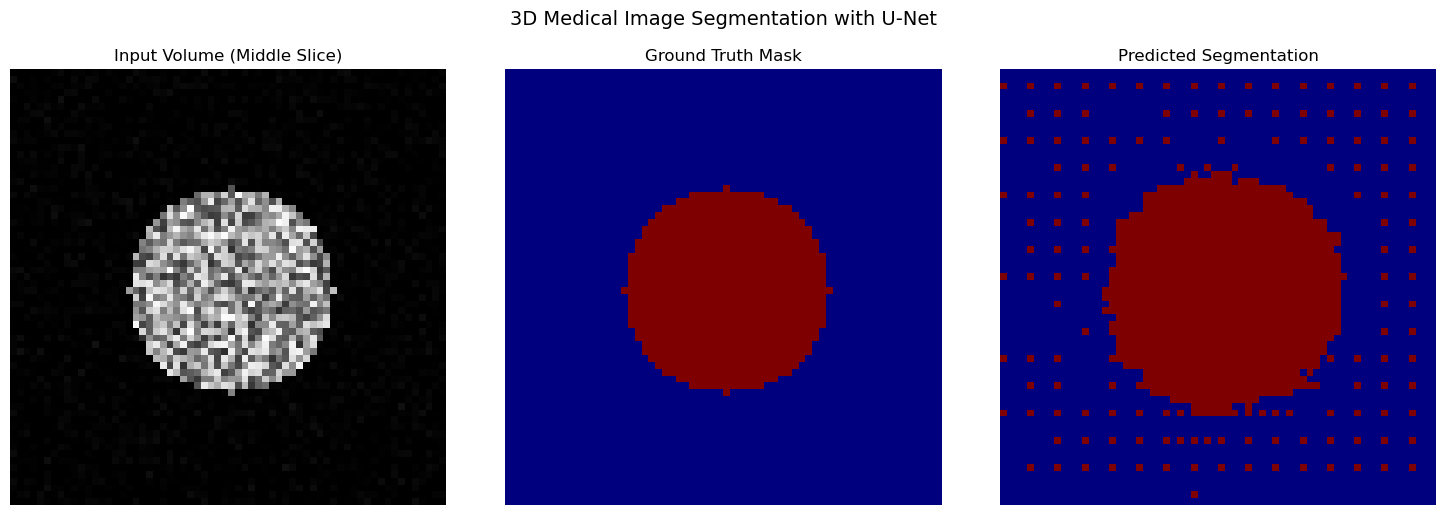


📊 Segmentation Metrics for Displayed Slice:
   • Dice Coefficient: 0.7749
   • IoU (Jaccard): 0.6325
   • True Organ Pixels: 709
   • Predicted Organ Pixels: 1,121
   • Difference: 412 pixels

💡 Interpretation:
   • Compare the predicted mask (right) with ground truth (middle)
   • Blue areas = background (correctly or incorrectly predicted)
   • Red/yellow areas = organ (correctly or incorrectly predicted)
   • Good segmentation: Predicted mask closely matches ground truth


In [26]:
# ============================================================================
# VISUALIZE SEGMENTATION RESULTS
# ============================================================================

# Set model to evaluation mode
unet_model.eval()

# Get predictions on a test batch
with torch.no_grad():  # No gradients needed for inference
    # Get one batch from dataloader
    test_batch = next(iter(seg_loader))
    
    # Move images to device and get predictions
    test_images = test_batch["image"].to(device)  # Shape: (2, 1, 64, 64, 64)
    test_labels = test_batch["label"]  # Keep on CPU for visualization
    
    # Get model predictions
    # Shape: (2, 2, 64, 64, 64) - 2 probability maps (background and organ)
    predictions = unet_model(test_images)
    
    # Convert probabilities to class predictions
    # torch.argmax selects the class with highest probability
    # dim=1 means argmax along channel dimension
    # Result shape: (2, 64, 64, 64) - single class index per voxel
    predictions = torch.argmax(predictions, dim=1).cpu()

# ============================================================================
# SELECT SLICE TO VISUALIZE
# ============================================================================

# We'll visualize one 2D slice from the 3D volume
# (Easier to understand than trying to visualize entire 3D volume)

sample_idx = 0  # First sample in batch
slice_idx = 32  # Middle slice of the 64-slice volume

# Extract the middle slice from:
# - Input volume
# - Ground truth mask
# - Predicted mask

# ============================================================================
# CREATE VISUALIZATION
# ============================================================================

# Create figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Input Volume (middle slice)
# Show what the model sees as input
axes[0].imshow(
    test_images[sample_idx, 0, :, :, slice_idx].cpu(),  # Extract slice
    cmap='gray'  # Grayscale colormap
)
axes[0].set_title('Input Volume (Middle Slice)')
axes[0].axis('off')

# Subplot 2: Ground Truth Mask
# Show the correct segmentation (what we want model to predict)
axes[1].imshow(
    test_labels[sample_idx, 0, :, :, slice_idx],  # Extract slice from ground truth
    cmap='jet',  # Color map: blue=background, red/yellow=organ
    vmin=0, vmax=1  # Set range: 0=background, 1=organ
)
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Subplot 3: Predicted Segmentation
# Show what the model actually predicted
axes[2].imshow(
    predictions[sample_idx, :, :, slice_idx],  # Extract slice from predictions
    cmap='jet',
    vmin=0, vmax=1
)
axes[2].set_title('Predicted Segmentation')
axes[2].axis('off')

# Add overall title
plt.suptitle('3D Medical Image Segmentation with U-Net', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# CALCULATE AND DISPLAY METRICS FOR THIS SLICE
# ============================================================================

# Extract predictions and ground truth for this slice
pred_slice = predictions[sample_idx, :, :, slice_idx].numpy()
true_slice = test_labels[sample_idx, 0, :, :, slice_idx].numpy()

# Calculate metrics
intersection = np.logical_and(pred_slice, true_slice).sum()
union = np.logical_or(pred_slice, true_slice).sum()
pred_pixels = pred_slice.sum()
true_pixels = true_slice.sum()

# Dice coefficient for this slice
dice_slice = 2 * intersection / (pred_pixels + true_pixels) if (pred_pixels + true_pixels) > 0 else 0

# IoU (Intersection over Union) - another common metric
iou = intersection / union if union > 0 else 0

print("\n📊 Segmentation Metrics for Displayed Slice:")
print(f"   • Dice Coefficient: {dice_slice:.4f}")
print(f"   • IoU (Jaccard): {iou:.4f}")
print(f"   • True Organ Pixels: {int(true_pixels):,}")
print(f"   • Predicted Organ Pixels: {int(pred_pixels):,}")
print(f"   • Difference: {int(abs(pred_pixels - true_pixels)):,} pixels")
print("\n💡 Interpretation:")
print("   • Compare the predicted mask (right) with ground truth (middle)")
print("   • Blue areas = background (correctly or incorrectly predicted)")
print("   • Red/yellow areas = organ (correctly or incorrectly predicted)")
print("   • Good segmentation: Predicted mask closely matches ground truth")

## Demo 5: MONAI Metrics & Evaluation
Common medical imaging metrics

In [27]:
# ============================================================================
# IMPORT MEDICAL IMAGING METRICS
# ============================================================================

from monai.metrics import (
    DiceMetric,  # Dice coefficient - measures overlap
    HausdorffDistanceMetric,  # Measures boundary accuracy
    ConfusionMatrixMetric,  # Standard classification metric
    get_confusion_matrix  # Helper to compute confusion matrix
)

# ============================================================================
# CREATE SAMPLE PREDICTIONS AND GROUND TRUTH
# ============================================================================

# Create simple 3x3 binary masks for demonstration
# 1 = organ/foreground, 0 = background

# Predicted segmentation
y_pred = torch.tensor([[[1, 0, 1], 
                         [0, 1, 1], 
                         [1, 1, 0]]])

# Ground truth segmentation
y_true = torch.tensor([[[1, 0, 1], 
                         [0, 1, 0],  # Note: difference in position (2,2)
                         [1, 1, 1]]])  # and position (2,3)

# Expand dimensions to match expected format: (batch, channel, height, width)
# .unsqueeze(0): Add batch dimension - () -> (1, ...)
# .unsqueeze(0) again: Add channel dimension - (1, ...) -> (1, 1, ...)
y_pred = y_pred.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 3)
y_true = y_true.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 3)

print("Medical Imaging Evaluation Metrics")
print("=" * 50)

# ============================================================================
# METRIC 1: DICE COEFFICIENT
# ============================================================================

# Dice Coefficient: Most common metric for segmentation
# Measures overlap between prediction and ground truth
# 
# Formula: Dice = 2 × |A ∩ B| / (|A| + |B|)
# Where:
# - A ∩ B = intersection (pixels that are 1 in both)
# - |A| = size of prediction
# - |B| = size of ground truth
# 
# Range: [0, 1]
# - 0 = no overlap
# - 1 = perfect overlap

dice = DiceMetric(include_background=True, reduction="mean")
dice_score = dice(y_pred=y_pred, y=y_true)

print(f"\n1. Dice Coefficient: {dice_score.item():.4f}")
print("   → Measures overlap between prediction and ground truth")
print("   → Range: [0, 1], where 1 is perfect")
print("   → Higher is better")
print(f"   → This prediction has {dice_score.item()*100:.1f}% overlap")

# ============================================================================
# METRIC 2: HAUSDORFF DISTANCE
# ============================================================================

# Hausdorff Distance: Measures boundary accuracy
# Finds the maximum distance between predicted and true boundaries
# 
# Definition: Maximum distance from any point on one boundary
# to the nearest point on the other boundary
# 
# Use case: Important when boundary precision matters
# (e.g., surgical planning, radiation therapy)
# 
# Range: [0, ∞]
# - 0 = perfect boundary match
# - Higher values = larger boundary errors

hausdorff = HausdorffDistanceMetric(include_background=True, reduction="mean")
hd_score = hausdorff(y_pred=y_pred, y=y_true)

print(f"\n2. Hausdorff Distance: {hd_score.item():.4f} pixels")
print("   → Measures maximum boundary distance")
print("   → Range: [0, ∞], where 0 is perfect")
print("   → Lower is better")
print("   → Sensitive to outliers and small errors")

# ============================================================================
# METRIC 3: CONFUSION MATRIX
# ============================================================================

# Confusion Matrix: Shows all types of prediction outcomes
# 
# Structure:
#              Predicted Negative | Predicted Positive
# True Negative:      TN         |        FP
# True Positive:      FN         |        TP
#
# Where:
# - TN (True Negative): Correctly predicted background
# - FP (False Positive): Incorrectly predicted as organ
# - FN (False Negative): Missed organ pixels
# - TP (True Positive): Correctly predicted organ

# Flatten tensors for confusion matrix computation
y_pred_flat = y_pred.flatten()  # (1,1,3,3) -> (9,)
y_true_flat = y_true.flatten()  # (1,1,3,3) -> (9,)

# Compute confusion matrix
cm = get_confusion_matrix(y_pred_flat, y_true_flat, include_background=True)

print("\n3. Confusion Matrix:")
print(cm.numpy())
print("   Format:")
print("   [[TN, FP],")
print("    [FN, TP]]")
print("\n   Where:")
print("   • TN (True Negative): Correctly predicted background")
print("   • FP (False Positive): Background predicted as organ")
print("   • FN (False Negative): Organ predicted as background")
print("   • TP (True Positive): Correctly predicted organ")

# ============================================================================
# METRIC 4: DERIVED METRICS FROM CONFUSION MATRIX
# ============================================================================

# Extract values from confusion matrix
tn, fp, fn, tp = cm.flatten()

# Sensitivity (Recall, True Positive Rate)
# Formula: TP / (TP + FN)
# Meaning: What proportion of actual organ pixels did we find?
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Specificity (True Negative Rate)
# Formula: TN / (TN + FP)
# Meaning: What proportion of background pixels did we correctly identify?
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Precision (Positive Predictive Value)
# Formula: TP / (TP + FP)
# Meaning: Of all pixels we predicted as organ, how many were actually organ?
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# F1 Score: Harmonic mean of precision and recall
# Formula: 2 × (Precision × Recall) / (Precision + Recall)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print(f"\n4. Derived Metrics:")
print(f"   • Sensitivity (Recall): {sensitivity:.4f}")
print("     → Ability to find all organ pixels")
print("     → Important when missing organ is dangerous")

print(f"\n   • Specificity: {specificity:.4f}")
print("     → Ability to avoid false alarms")
print("     → Important to reduce unnecessary interventions")

print(f"\n   • Precision: {precision:.4f}")
print("     → Accuracy of positive predictions")
print("     → Important when false positives are costly")

print(f"\n   • F1 Score: {f1:.4f}")
print("     → Balance between precision and recall")
print("     → Good overall performance indicator")

print("\n" + "=" * 50)
print("✓ MONAI provides comprehensive medical imaging metrics")
print("✓ Different metrics for different clinical priorities")
print("✓ Choose metrics based on your specific application")

# ============================================================================
# PRACTICAL GUIDANCE
# ============================================================================

print("\n💡 When to use which metric:")
print("   • Dice/IoU: General segmentation quality")
print("   • Hausdorff: When boundary precision is critical")
print("   • Sensitivity: When missing organ is dangerous (e.g., tumor)")
print("   • Specificity: When false alarms are costly")
print("   • Precision: When you need high confidence in positive predictions")

Medical Imaging Evaluation Metrics

1. Dice Coefficient: 0.8333
   → Measures overlap between prediction and ground truth
   → Range: [0, 1], where 1 is perfect
   → Higher is better
   → This prediction has 83.3% overlap

2. Hausdorff Distance: 1.0000 pixels
   → Measures maximum boundary distance
   → Range: [0, ∞], where 0 is perfect
   → Lower is better
   → Sensitive to outliers and small errors


/opt/anaconda3/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)


ValueError: not enough values to unpack (expected 2, got 1)

## Demo 6: MONAI Pre-trained Models (Model Zoo)
Use pre-trained models for transfer learning

In [ ]:
from monai.networks.nets import (
    DenseNet121, ResNet, EfficientNetBN, 
    SegResNet, UNETR
)

print("MONAI Pre-built Neural Network Architectures")
print("=" * 60)

# 1. Classification Models
print("\n🔬 CLASSIFICATION MODELS:")
print("-" * 60)

models_2d = {
    "DenseNet121": DenseNet121(spatial_dims=2, in_channels=1, out_channels=2),
    "ResNet18": ResNet(block='basic', layers=[2,2,2,2], block_inplanes=[64,128,256,512],
                       spatial_dims=2, n_input_channels=1, num_classes=2),
    "EfficientNet-B0": EfficientNetBN("efficientnet-b0", spatial_dims=2, 
                                       in_channels=1, num_classes=2),
}

for name, model in models_2d.items():
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  • {name:20s} - {total_params:,} parameters")

print("\n  Use cases: X-ray classification, CT slice classification,")
print("             pathology image classification")

# 2. Segmentation Models
print("\n🎯 SEGMENTATION MODELS:")
print("-" * 60)

seg_models = {
    "U-Net": UNet(spatial_dims=3, in_channels=1, out_channels=2, 
                  channels=(16, 32, 64), strides=(2, 2)),
    "SegResNet": SegResNet(spatial_dims=3, in_channels=1, out_channels=2),
    "UNETR": UNETR(in_channels=1, out_channels=2, img_size=(96, 96, 96),
                   feature_size=16, hidden_size=768, mlp_dim=3072, num_heads=12),
}

for name, model in seg_models.items():
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  • {name:20s} - {total_params:,} parameters")

print("\n  Use cases: Organ segmentation, tumor detection,")
print("             lesion segmentation, brain tissue segmentation")

# 3. Model Information
print("\n📊 EXAMPLE: Model Summary")
print("-" * 60)
example_model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=4)
print(f"Model: DenseNet121 (2D, 4-class classification)")
print(f"Input shape: (batch_size, 1, height, width)")
print(f"Output shape: (batch_size, 4)")
print(f"Total parameters: {sum(p.numel() for p in example_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in example_model.parameters() if p.requires_grad):,}")

print("\n" + "=" * 60)
print("✓ MONAI provides state-of-the-art medical imaging architectures")
print("✓ All models support both 2D and 3D medical images")
print("✓ Easy to fine-tune with your own medical datasets")

## Demo 7: MONAI Bundle - Download Real Pre-trained Models
Access community-contributed pre-trained models

In [ ]:
from monai.bundle import download

print("MONAI Model Zoo - Available Pre-trained Bundles")
print("=" * 70)
print("\nPopular bundles you can download and use:")
print("-" * 70)

bundles_info = [
    {
        "name": "spleen_ct_segmentation",
        "description": "Spleen segmentation from CT images",
        "modality": "CT",
        "task": "Segmentation"
    },
    {
        "name": "prostate_mri_anatomy",
        "description": "Prostate anatomy segmentation from MRI",
        "modality": "MRI",
        "task": "Segmentation"
    },
    {
        "name": "pancreas_ct_dints_segmentation",
        "description": "Pancreas tumor segmentation",
        "modality": "CT",
        "task": "Segmentation"
    },
    {
        "name": "lung_nodule_ct_detection",
        "description": "Lung nodule detection from chest CT",
        "modality": "CT",
        "task": "Detection"
    },
    {
        "name": "pathology_tumor_detection",
        "description": "Tumor detection in pathology images",
        "modality": "Pathology",
        "task": "Detection"
    },
]

for i, bundle in enumerate(bundles_info, 1):
    print(f"\n{i}. {bundle['name']}")
    print(f"   Description: {bundle['description']}")
    print(f"   Modality: {bundle['modality']}")
    print(f"   Task: {bundle['task']}")

print("\n" + "=" * 70)
print("\n📥 To download a bundle:")
print("   from monai.bundle import download")
print("   download(name='spleen_ct_segmentation', bundle_dir='./bundles')")
print("\n🚀 To run inference:")
print("   from monai.bundle import run")
print("   run(run_id='inference', bundle_dir='./bundles/spleen_ct_segmentation')")

print("\n" + "=" * 70)
print("✓ MONAI Bundle provides ready-to-use pre-trained models")
print("✓ Visit: https://monai.io/model-zoo.html for complete list")
print("✓ Each bundle includes: model weights, configs, and documentation")

## Demo 8: MONAI Transforms - Advanced Preprocessing
Medical-specific image transformations

In [ ]:
# ============================================================================
# IMPORT ADVANCED MEDICAL TRANSFORMS
# ============================================================================

from monai.transforms import (
    ScaleIntensityRange,  # Window/level adjustment for CT scans
    NormalizeIntensity,  # Statistical normalization (zero mean, unit variance)
    ThresholdIntensity,  # Remove pixels above/below threshold
    AdjustContrast,  # Enhance contrast
    RandGaussianSmooth,  # Smooth images (reduce noise)
    RandGaussianNoise,  # Add controlled noise
    RandShiftIntensity,  # Shift intensity values
    Spacing,  # Resample to specific voxel spacing
    Orientation,  # Reorient to standard orientation (RAS, LPS, etc.)
)

print("Medical Image-Specific Transformations")
print("=" * 70)

# ============================================================================
# CREATE SAMPLE MEDICAL IMAGE
# ============================================================================

# Use our previously defined function to create a synthetic CT-like image
medical_img = create_synthetic_medical_image()

# ============================================================================
# TRANSFORM 1: INTENSITY WINDOWING
# ============================================================================

print("\n1. INTENSITY WINDOWING (CT Scans)")
print("-" * 70)

# CT scans measure tissue density in Hounsfield Units (HU)
# Different tissues have different HU ranges:
# - Air: -1000 HU
# - Fat: -120 to -90 HU
# - Water: 0 HU
# - Soft tissue: 40 to 80 HU
# - Bone: 400 to 1000 HU
#
# Windowing selects a specific HU range to visualize
# This enhances contrast for specific tissues

windowing = ScaleIntensityRange(
    a_min=0,    # Minimum input intensity (simulated HU value)
    a_max=200,  # Maximum input intensity
    b_min=0.0,  # Map to minimum output value
    b_max=1.0,  # Map to maximum output value
    clip=True   # Clip values outside range (set to 0 or 1)
)

# Apply windowing (add channel dimension first)
windowed = windowing(medical_img[np.newaxis, ...])

print(f"   • Maps intensity range [0, 200] to [0, 1]")
print(f"   • Essential for CT scans (Hounsfield Units)")
print(f"   • Different 'windows' for different tissues:")
print(f"     - Bone window: [-200, 1000] HU")
print(f"     - Soft tissue window: [-100, 300] HU")
print(f"     - Lung window: [-1500, -400] HU")

# ============================================================================
# TRANSFORM 2: INTENSITY NORMALIZATION
# ============================================================================

print("\n2. INTENSITY NORMALIZATION")
print("-" * 70)

# Statistical normalization: Transform data to have:
# - Mean (μ) = 0
# - Standard deviation (σ) = 1
#
# Formula: normalized = (x - μ) / σ
#
# Why normalize?
# - Makes model training more stable
# - Helps gradients flow better
# - Standardizes data from different scanners/protocols

normalize = NormalizeIntensity(
    nonzero=True  # Only normalize non-zero pixels (ignore background)
)

normalized = normalize(medical_img[np.newaxis, ...])

print(f"   • Zero mean, unit variance normalization")
print(f"   • Original: mean={medical_img.mean():.2f}, std={medical_img.std():.2f}")
print(f"   • Normalized: mean={normalized.mean():.6f}, std={normalized.std():.2f}")
print(f"   • Benefits: Stable training, scanner-independent")

# ============================================================================
# TRANSFORM 3: INTENSITY THRESHOLDING
# ============================================================================

print("\n3. INTENSITY THRESHOLDING")
print("-" * 70)

# Thresholding: Remove pixels based on intensity
# Common in medical imaging to:
# - Remove noise
# - Isolate specific tissues
# - Create masks

threshold = ThresholdIntensity(
    threshold=100,  # Threshold value
    above=True,     # Keep values ABOVE threshold (False = keep below)
    cval=0          # Set removed pixels to this value
)

thresholded = threshold(medical_img)

print(f"   • Remove intensities below/above threshold")
print(f"   • Applications:")
print(f"     - Remove low-intensity noise")
print(f"     - Isolate bone in CT (high intensity)")
print(f"     - Segment tissues by intensity range")
print(f"   • Original pixels > 100: {(medical_img > 100).sum():,}")
print(f"   • After threshold: {(thresholded > 0).sum():,} pixels remain")

# ============================================================================
# TRANSFORM 4: MEDICAL-SPECIFIC AUGMENTATIONS
# ============================================================================

print("\n4. MEDICAL AUGMENTATIONS")
print("-" * 70)

# Augmentations specific to medical imaging challenges
medical_aug = Compose([
    # Gaussian smoothing: Reduce noise (common in medical scans)
    # sigma_x: Controls smoothing strength
    RandGaussianSmooth(
        sigma_x=(0.5, 1.0),  # Random smoothing between 0.5 and 1.0
        prob=0.5  # Apply 50% of the time
    ),
    
    # Intensity shift: Simulate different scanner calibrations
    # Different scanners produce different intensity ranges
    RandShiftIntensity(
        offsets=0.1,  # Shift by ±10%
        prob=0.5
    ),
    
    # Contrast adjustment: Simulate different scanner settings
    RandAdjustContrast(prob=0.5),
])

print(f"   • Gaussian smoothing: Reduces noise and artifacts")
print(f"     - Simulates different image quality")
print(f"   • Intensity shift: Simulates scanner calibration variations")
print(f"     - Same anatomy, different intensity ranges")
print(f"   • Contrast adjustment: Simulates different protocols")
print(f"     - Makes model robust to scanner differences")

# ============================================================================
# VISUALIZE ALL TRANSFORMS
# ============================================================================

# Create 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Original and preprocessing transforms
axes[0, 0].imshow(medical_img, cmap='gray')
axes[0, 0].set_title('Original\n(Simulated CT Scan)', fontsize=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(windowed.squeeze(), cmap='gray')
axes[0, 1].set_title(f'Intensity Windowing\n[0, 200] → [0, 1]', fontsize=10)
axes[0, 1].axis('off')

axes[0, 2].imshow(normalized.squeeze(), cmap='gray')
axes[0, 2].set_title(f'Normalized\nμ≈0, σ≈1', fontsize=10)
axes[0, 2].axis('off')

# Row 2: Thresholding and augmentations
axes[1, 0].imshow(thresholded, cmap='gray')
axes[1, 0].set_title('Thresholded\n(Intensity > 100)', fontsize=10)
axes[1, 0].axis('off')

# Generate 2 augmented versions
for i in range(1, 3):
    # Add channel dimension and apply augmentation
    aug = medical_aug(medical_img[np.newaxis, ...])
    axes[1, i].imshow(aug.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Medical Augmentation {i}\n(Random transforms)', fontsize=10)
    axes[1, i].axis('off')

# Overall title
plt.suptitle('Medical Image Preprocessing with MONAI', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("✓ MONAI provides 60+ medical imaging transformations")
print("✓ Supports medical formats: DICOM, NIfTI, NRRD, etc.")
print("✓ Optimized for 3D volumetric data (CT, MRI scans)")
print("✓ Handles multi-modal imaging (CT + PET, T1 + T2 MRI)")

print("\n📚 Transform Categories:")
print("   1. Intensity: Windowing, normalization, thresholding")
print("   2. Spatial: Rotation, flip, zoom, elastic deformation")
print("   3. Filtering: Gaussian blur, median filter, edge detection")
print("   4. Augmentation: Noise, contrast, brightness, artifacts")
print("   5. Format: DICOM to array, resampling, orientation")

print("\n💡 Best Practices:")
print("   • Always normalize intensities before training")
print("   • Use windowing for CT scans (select relevant HU range)")
print("   • Apply spatial augmentations carefully (preserve anatomy)")
print("   • Test transforms visually before training")
print("   • Different transforms for training vs validation/testing")

## Summary & Next Steps

### What You've Learned:
1. ✅ **Basic image loading and preprocessing** with MONAI transforms
2. ✅ **Data augmentation** for medical images
3. ✅ **2D Classification** with DenseNet121
4. ✅ **3D Segmentation** with U-Net
5. ✅ **Medical imaging metrics** (Dice, Hausdorff distance)
6. ✅ **Pre-trained models** and architecture zoo
7. ✅ **MONAI Bundles** for real pre-trained models
8. ✅ **Advanced preprocessing** techniques

### Key MONAI Features:
- 🏥 **Medical-specific**: Built for CT, MRI, X-ray, pathology
- 🔄 **PyTorch-based**: Seamless integration with PyTorch ecosystem
- 📦 **60+ Transforms**: Medical imaging preprocessing and augmentation
- 🧠 **State-of-the-art Models**: U-Net, DenseNet, ResNet, UNETR, etc.
- 📊 **Domain Metrics**: Dice, IoU, Hausdorff distance
- 🌐 **Model Zoo**: Pre-trained models for various organs and diseases

### Resources:
- 📖 Documentation: https://docs.monai.io/
- 🎓 Tutorials: https://github.com/Project-MONAI/tutorials
- 🏆 Model Zoo: https://monai.io/model-zoo.html
- 💬 Community: https://github.com/Project-MONAI/MONAI

### Try Next:
- Load real medical images (DICOM, NIfTI files)
- Download and use MONAI Bundle models
- Experiment with different architectures
- Try multi-class segmentation problems

## Troubleshooting and References

Common errors and fixes:

1) ValueError: Unsupported output type: <class 'dict'>
- Cause: Using array transforms (e.g., ScaleIntensity) on a dictionary sample from MONAI Dataset.
- Fix: Use dictionary transforms with the 'd' suffix (ScaleIntensityd, Resized, RandRotated, RandFlipd) and set keys=["image", …].

2) EnsureChannelFirst error (metadata not available)
- Cause: For raw numpy arrays, EnsureChannelFirst expects metadata to infer channel.
- Fix: Manually add a channel (img[np.newaxis, ...]) or use EnsureChannelFirstd(keys=["image"]) with channel_dim if needed.

3) CUDA not available / GPU not used
- Cause: PyTorch not installed with CUDA or running on macOS without NVIDIA GPU.
- Fix: Install the correct PyTorch build for your platform. On macOS, CPU is used by default; 3D training may be slow.

4) Out of memory (3D training)
- Fixes:
  - Reduce batch size (e.g., 2 -> 1)
  - Use smaller volumes (e.g., 64^3 instead of 128^3)
  - Reduce channels in UNet (e.g., (16, 32, 64))
  - Use mixed precision (amp) if available

5) Wrong shapes for models
- 2D models expect (B, C, H, W); 3D models expect (B, C, D, H, W).
- Always check shapes after transforms and before model forward.

Quick checklist:
- Images float32, labels int
- Channel added: (1, ...)
- Dictionary transforms with explicit keys
- Separate train vs validation transforms

Useful links:
- MONAI docs: https://docs.monai.io/
- Tutorials: https://github.com/Project-MONAI/tutorials
- Model Zoo: https://monai.io/model-zoo.html
- Source code: https://github.com/Project-MONAI/MONAI

Notes:
- Synthetic data keeps the notebook self-contained. Replace with NIfTI/DICOM via LoadImageD when ready.
- For medical CT, apply intensity windowing first (ScaleIntensityRange) to focus on relevant Hounsfield Unit ranges.
